# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Данные геологоразведки трёх регионов находятся в файлах:
- /datasets/geo_data_0.csv.
- /datasets/geo_data_1.csv.
- /datasets/geo_data_2.csv.

Описание столбцов:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

*Загрузим необходимые бибилиотеки*

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
import seaborn as sns
from scipy import stats as st # для доверительного интервала
pd.set_option('display.float_format', '{:.3f}'.format) # значения float до 3 знаков после запятой

warnings.filterwarnings('ignore')  # уберем некритические предупреждения в коде

*Загрузим данные геологоразведки трёх регионов:*

In [ ]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')
display(data_0.head())
display(data_1.head())
display(data_2.head())

,id,f0,f1,f2,product
0,txEyH,0.706,-0.498,1.221,105.280
1,2acmU,1.335,-0.340,4.365,73.038
2,409Wp,1.023,0.152,1.420,85.266
3,iJLyR,-0.032,0.139,2.979,168.621
4,Xdl7t,1.988,0.155,4.752,154.037


,id,f0,f1,f2,product
0,kBEdx,-15.001,-8.276,-0.006,3.179
1,62mP7,14.272,-3.475,0.999,26.953
2,vyE1P,6.263,-5.948,5.001,134.766
3,KcrkZ,-13.081,-11.506,4.999,137.945
4,AHL4O,12.702,-8.147,5.004,134.766


,id,f0,f1,f2,product
0,fwXo0,-1.147,0.963,-0.829,27.759
1,WJtFt,0.263,0.270,-2.530,56.070
2,ovLUW,0.195,0.289,-5.586,62.872
3,q6cA6,2.236,-0.554,0.930,114.573
4,WPMUX,-0.516,1.716,5.899,149.601


*Изучим основную информацию.*

In [ ]:
display(data_0.info())
display(data_1.info())
display(data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

*Посмотрим основные статистические показатели данных.*

In [ ]:
print('Data_0 describe:')
display(data_0.describe())
print('Data_1 describe:')
display(data_1.describe())
print('Data_2 describe:')
display(data_2.describe())

Data_0 describe:


,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.500,0.250,2.503,92.500
std,0.872,0.504,3.248,44.289
min,-1.409,-0.848,-12.088,0.000
25%,-0.073,-0.201,0.288,56.498
50%,0.502,0.250,2.516,91.850
75%,1.074,0.701,4.715,128.564
max,2.362,1.344,16.004,185.364


Data_1 describe:


,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,1.141,-4.797,2.495,68.825
std,8.966,5.120,1.704,45.944
min,-31.610,-26.359,-0.018,0.000
25%,-6.299,-8.268,1.000,26.953
50%,1.153,-4.813,2.011,57.086
75%,8.621,-1.333,4.000,107.813
max,29.422,18.734,5.020,137.945


Data_2 describe:


,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.002,-0.002,2.495,95.000
std,1.732,1.730,3.473,44.750
min,-8.760,-7.084,-11.970,0.000
25%,-1.162,-1.175,0.130,59.450
50%,0.009,-0.009,2.484,94.926
75%,1.159,1.164,4.859,130.595
max,7.238,7.845,16.739,190.030


*Построим матрицу корреляций.*

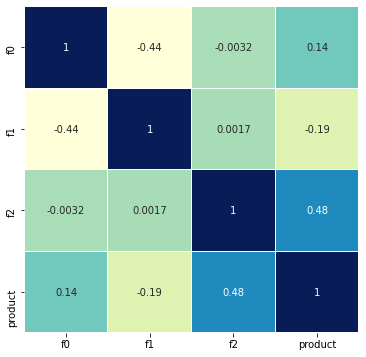

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(data_0.corr(), annot=True, cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.show()

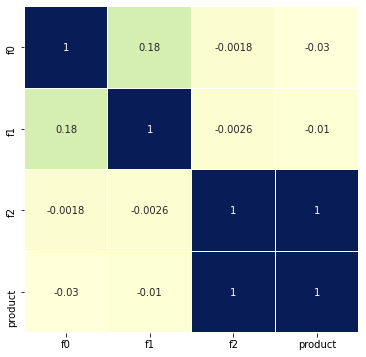

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(data_1.corr(), annot=True, cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.show()

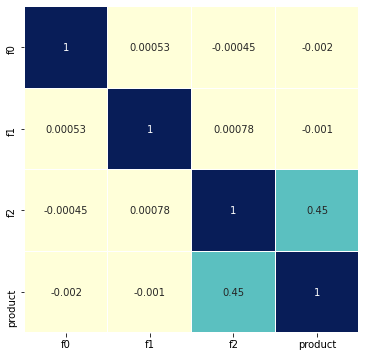

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(data_2.corr(), annot=True, cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.show()

*Корреляции между признаками практически нет. Во втором регионе есть прямая корреляция от признака. Данная ситуация допустима и говорит о том, что объем добываемой нефти в этом регионе напрямую зависит от признака f2.*

*Проверим данные на пропущенные значения.*

In [ ]:
data_0.isna().sum(), data_1.isna().sum(), data_2.isna().sum()

(id         0
 f0         0
 f1         0
 f2         0
 product    0
 dtype: int64,
 id         0
 f0         0
 f1         0
 f2         0
 product    0
 dtype: int64,
 id         0
 f0         0
 f1         0
 f2         0
 product    0
 dtype: int64)

*Проверим данные на дубликаты.*

In [ ]:
data_0.duplicated().sum(), data_1.duplicated().sum(), data_2.duplicated().sum()

(0, 0, 0)

*Для нашей задачи столбец 'id' не потребуется. Удалим его из каждой таблицы.*

In [ ]:
data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

**Вывод:**
* В представленных данных отсутствуют пропуски.
* Корреляции между признаками практически нет.
* Удален столбец 'id' из таблиц, так как он не потребуется для дальнейшего анализа и обучения.
* Дубликаты в данных отсутствуют.
* Данные готовы для разделения на выборки и последующего обучения.

## Обучение и проверка модели

### Разбьём данные на обучающую и валидационную выборки для каждого региона в соотношении 75:25.

*Напишем функцию для разбивки данных на обучающие и валидационные выборки.*

In [ ]:
def split_data(data, target):
    features = data.drop([target], axis=1)
    target = data[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

    return features_train, features_valid, target_train, target_valid

*Получим features и target для 3-х регионов.*

In [ ]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split_data(data_0, 'product')
print('Размер обучающей выборки для первого региона',\
     features_train_0.shape,\
     target_train_0.shape)
print('Размер валидационной выборки для первого региона',\
     features_valid_0.shape,\
     target_valid_0.shape)
print()
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_data(data_1, 'product')
print('Размер обучающей выборки для второго региона',\
     features_train_1.shape,\
     target_train_1.shape)
print('Размер валидационной выборки для второго региона',\
     features_valid_1.shape,\
     target_valid_1.shape)
print()
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_data(data_2, 'product')
print('Размер обучающей выборки для третьего региона',\
     features_train_2.shape,\
     target_train_2.shape)
print('Размер валидационной выборки для третьего региона',\
     features_valid_2.shape,\
     target_valid_2.shape)

Размер обучающей выборки для первого региона (75000, 3) (75000,)
Размер валидационной выборки для первого региона (25000, 3) (25000,)

Размер обучающей выборки для второго региона (75000, 3) (75000,)
Размер валидационной выборки для второго региона (25000, 3) (25000,)

Размер обучающей выборки для третьего региона (75000, 3) (75000,)
Размер валидационной выборки для третьего региона (25000, 3) (25000,)


*Проверим необходимость масштабирования признаков.*

In [ ]:
model = LinearRegression() # инициализируем модель LinearRegression

model.fit(features_train_0, target_train_0)
predicted_target_0 = model.predict(features_valid_0)
print('Немасштабированные данные RMSE: {:.3f}'.format(mean_squared_error(target_valid_0, predicted_target_0)**0.5))

Немасштабированные данные RMSE: 37.579


In [ ]:
features_train_0m, features_valid_0m, target_train_0m, target_valid_0m = split_data(data_0, 'product')

numeric = ['f0', 'f1', 'f2']
scaler = StandardScaler()
scaler.fit(features_train_0m[numeric])
features_train_0m[numeric] = scaler.transform(features_train_0m[numeric])
features_valid_0m[numeric] = scaler.transform(features_valid_0m[numeric])

model.fit(features_train_0m, target_train_0m)
predicted_target_0m = model.predict(features_valid_0m)

print('Масштабированные данные RMSE: {:.3f}'.format(mean_squared_error(target_valid_0m, predicted_target_0m)**0.5))

Масштабированные данные RMSE: 37.579


*Одинаковые метрики RMSE масштабированных и немасштабированных данных говорят о том, что в масштабировании признаков модели нет необходимости.*

### Обучим модель и сделаем предсказания на валидационной выборке.

In [ ]:
#функция для обучения и предсказания модели.
def model_prediction(features_train, features_valid, target_train, target_valid):

    model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predicted_valid = model.predict(features_valid) # получаем предсказания модели на валидационной выборке
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5 # считаем значение метрики RMSE на валидационной выборке
    mean_product = predicted_valid.mean()

    return predicted_valid, rmse, mean_product,

### Сохраним предсказания и правильные ответы на валидационной выборке.

In [ ]:
# получим данные для всех регионов
predicted_valid_0, rmse_0, mean_product_0 = model_prediction(features_train_0, features_valid_0, target_train_0, target_valid_0)
predicted_valid_1, rmse_1, mean_product_1 = model_prediction(features_train_1, features_valid_1, target_train_1, target_valid_1)
predicted_valid_2, rmse_2, mean_product_2 = model_prediction(features_train_2, features_valid_2, target_train_2, target_valid_2)

### Напечатаем на экране средний запас истинного, предсказанного сырья и RMSE модели.

*Оценим истинные, предсказанные средние запасы и RMSE по регионам и сведем в таблицу для наглядности.*

In [ ]:
model_results = pd.DataFrame({'real_target_mean'        :[target_valid_0.mean(),     # истинные средние запасы
                                                               target_valid_1.mean(),
                                                               target_valid_2.mean()],
                              'predict_target_mean'      : [mean_product_0.mean(),   # предсказанные средние запасы
                                                                mean_product_1.mean(),
                                                                mean_product_2.mean()],
                              'RMSE'                         : [rmse_0,              # RMSE
                                                                rmse_1,
                                                                rmse_2],
}
)

model_results


,real_target_mean,predict_target_mean,RMSE
0,92.079,92.593,37.579
1,68.723,68.729,0.893
2,94.884,94.965,40.030


**Вывод:**

* разбили данные на обучающую и валидационную выборки для каждого региона в соотношении 75:25
* проверили необходимость масштабирования признаков - необходимости нет
* инициировали модель линейной регрессии, обучили и получили предсказания
* модель предсказывает значения, которые близки к истинным во всех трёх регионах
* первый и третий регион наиболее перспективные по среднему предсказанному запасу сырья
* минимальное значение RMSE получено для 2-го региона

## Подготовка к расчёту прибыли

### Сохраним все ключевые значения для расчётов в отдельных переменных.

In [ ]:
all_points = 500 # количество точек для исследования
best_points = 200 # количество точек для разработки
budget = 10**10 # бюджет на разработку скважин в регионе
revenue_barrel = 450* 10**3 # доход с 1 тыс баррель
loss_probability = 0.025 # максимальная вероятность убытков
bootstrap_samples = 1000

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

*Рассчитаем объём сырья для безубыточной разработки новой скважины:*

*1. Вычислим допустимые средние затраты на разработку одной скважины - разделим бюджет на количество скважин.*

*2. Вычислим какое количество в тыс. баррель необходимо для покрытия затрат на одну скважину.*

In [ ]:
expenses_well_mean = budget/best_points
breakeven_volume_well = expenses_well_mean/revenue_barrel
print('Достаточный объём сырья для безубыточной разработки новой скважины {:.3f}'.format(breakeven_volume_well), 'тыс. барелей')


Достаточный объём сырья для безубыточной разработки новой скважины 111.111 тыс. барелей


*Сравним объём сырья для безубыточной торговли со средним запасом в каждом регионе.*

In [ ]:
for i in model_results['real_target_mean']:
    if i < breakeven_volume_well:
        print('Объём сырья в', model_results.index[model_results['real_target_mean']==i].tolist(),\
              'регионе недостаточен для безубыточной торговли.')
        print('Разница объёма сырья составляет: {:.3f}'.format(i-breakeven_volume_well), 'тыс. барелей',)
        print()
    else:
        print('Объём сырья в', model_results.index[model_results['real_target_mean']==i].tolist(),\
              'регионе достаточен для безубыточной торговли.')

Объём сырья в [0] регионе недостаточен для безубыточной торговли.
Разница объёма сырья составляет: -19.033 тыс. барелей

Объём сырья в [1] регионе недостаточен для безубыточной торговли.
Разница объёма сырья составляет: -42.388 тыс. барелей

Объём сырья в [2] регионе недостаточен для безубыточной торговли.
Разница объёма сырья составляет: -16.227 тыс. барелей



### Выводы по этапу подготовки расчёта прибыли.

* Рассчитали достаточный объём сырья для безубыточной разработки новой скважины: 111.111 тыс. барелей.
* Объём сырья во всех трёх регионах недостаточен для безубыточной торговли.
* После проведения рассчетов достаточного объёма сырья для безубыточной разработки новой скважины и сравнения со средними значением запасов по трём регионам пришли к выводу, что высока доля риска неокупаемости затраченного бюджета при разработке скважин, выбранных случайным образом.
* Наименьшая разница объема сырья у третьего региона, наибольшая у второго.

## Расчёт прибыли и рисков

### Выберем скважины с максимальными значениями предсказаний.

In [ ]:
def revenue (target, probabilities, best_points):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities).reset_index(drop=True)
    # сортируем скважины с максимальным объемом нефти
    pred_choice = probabilities.sort_values(ascending=False)
    # определяем верные значения для отобранных случайных скважин и берем только нужное количество
    target_choice = target[pred_choice.index][:best_points]
    income = target_choice.sum() * revenue_barrel - budget # доход в млн. рублей
    return income

### Рассчитаем прибыль для полученного объёма сырья для каждого региона.

In [ ]:
print('Прибыль в с 200 выбранных по предсказаниям модели скважин составит:')
print('для региона 1: {:.3f} руб.'.format(revenue(target_valid_0, predicted_valid_0, best_points)))
print('для региона 2: {:.3f} руб.'.format(revenue(target_valid_1, predicted_valid_1, best_points)))
print('для региона 3: {:.3f} руб.'.format(revenue(target_valid_2, predicted_valid_2, best_points)))

Прибыль в с 200 выбранных по предсказаниям модели скважин составит:
для региона 1: 3320826043.140 руб.
для региона 2: 2415086696.682 руб.
для региона 3: 2710349963.600 руб.


*Получили очень высокие значения прибыли для каждого региона. Данные значения мы можем получить, если проведем геолоразведку по всем точкам и выберем 200 лучших, что повлечет за собой большие затраты. Согласно требованиям заказчика мы можем провести геолоразведку только по 500 точкам.*

## Посчитаем риски и прибыль для каждого региона.

### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

*Напишем функцию для расчета выручки для 500 случайных скважин, определим распределение прибыли с помощью техники Bootstrap для 1000 выборок. Определим среднюю выручку, доверительный интервал и риски.*

In [ ]:
def bootstrap(target_valid, predicted_valid, bootstrap_samples, all_points):
    state = np.random.RandomState(12345)
    values = []
    for i in range(bootstrap_samples):
        target_subsample = target_valid.sample(n=all_points, random_state=state, replace=True)
        probs_subsample = predicted_valid[target_subsample.index]
        values.append(revenue(target_subsample, probs_subsample, best_points))

    values = pd.Series(values)
    mean = values.mean()
    risk = (values < 0).mean()*100

    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    return round(mean,2), round(risk, 2), lower, upper

### Посчитаем нужные нам показатели для каждого региона.

In [ ]:
mean_0, risk_0, lower_0, upper_0 = bootstrap(target_valid_0.reset_index(drop=True),\
                                             predicted_valid_0, bootstrap_samples, all_points)
mean_1, risk_1, lower_1, upper_1 = bootstrap(target_valid_1.reset_index(drop=True),\
                                             predicted_valid_1, bootstrap_samples, all_points)
mean_2, risk_2, lower_2, upper_2 = bootstrap(target_valid_2.reset_index(drop=True),\
                                             predicted_valid_2, bootstrap_samples, all_points)

*Сведем все показатели в итоговую таблицу для наглядности.*

In [ ]:
final_results = pd.DataFrame({'Средняя прибыль по региону, руб'        :[mean_0, mean_1, mean_2],
                              '95% доверительный интервал от'     : [lower_0, lower_1, lower_2],
                              '95% доверительный интервал до'     : [upper_0, upper_1, upper_2],
                              'Процент риска'                     : [risk_0, risk_1, risk_2]},
                             index=['Регион 1','Регион 2','Регион 3'])

final_results

,"Средняя прибыль по региону, руб",95% доверительный интервал от,95% доверительный интервал до,Процент риска
Регион 1,396164984.800,-111215545.890,909766941.553,6.900
Регион 2,456045105.790,33820509.399,852289453.866,1.500
Регион 3,404403866.570,-163350413.396,950359574.924,7.600


**Вывод:**

* Исследовали и подготовили данные по трем регионам для обучения модели.
* Разбили данные на обучающую и валидационную выборки для каждого региона в соотношении 75:25.
* Инициировали модель линейной регрессии, обучили и получили предсказания.
* Модель предсказывает значения, которые близки к истинным во всех трёх регионах.
* Первый и третий регион наиболее перспективные по среднему предсказанному запасу сырья.
* Минимальное значение RMSE получено для 2-го региона.
* Рассчитали достаточный объём сырья для безубыточной разработки новой скважины: 111.111 тыс. барелей.
* После проведения рассчетов достаточного объёма сырья для безубыточной разработки новой скважины и сравнения со средними значением запасов по трём регионам пришли к выводу, что высока доля риска неокупаемости затраченного бюджета при разработке скважин, выбранных случайным образом.
* При расчете средней выручки по трем регионам, все являются прибыльными:

  Регион 1:   396164984.800 руб.

  Регион 2:   456045105.790 руб

  Регион 3:   404403866.570 руб


* У региона 1 и 3 высокая вероятность убытков - 6.9% и 7.6% соответственно, и не проходят по условиям бизнес-задачи.
* Ситуация вероятности убытков регионов 1 и 3 хорошо описывается 95-% доврительным интервалом. Левая граница, которая отделяет 2.5 % данных для 1-го и 3-го регионов, принимает отрицательное значение, что говорит о том, что более 2.5 % выборок имеют отрицательную прибыль.
* Регион 2 лидирует по всем показателям: наибольший средний чек, имеет наименьшую вероятность убытков, которая проходит по условиям бизнес-задачи.


**Для разработки рекомендуется Регион 2 по следующим причинам:**

* минимальная вероятность убытков - 1.5%
* максимальная средняя прибыль из предложенных для анализа регионов
* левая граница 95-% доверительного интервала положительная
